#**CHAPTER 10. MULTIMODAL AI**
---

##0.REFERENCE

https://chatgpt.com/share/698641ef-0ad4-8012-b9e1-54d020dc150e

##1.CONTEXT

**INTRODUCTION**

This notebook accompanies Paper 10 in the AI 2026 collection, focused on multimodal frontier systems that couple perception, language, and action under real-world constraints. The term “Vision–Language–Action” (VLA) is used here as a conceptual shorthand for a broad class of systems that ingest heterogeneous inputs, construct an internal interpretation, and produce decisions that change the state of the world. In such systems, technical performance is inseparable from governance performance, because the outputs are not merely statements; they are action selections that may carry operational, legal, or reputational consequences.

The motivating risk examined here is multimodal instruction injection. While injection is often discussed in the context of pure text prompting, real systems increasingly accept images, documents, screenshots, charts, and other media whose content can influence downstream reasoning. The mechanism is not mysterious: if a model or pipeline extracts text from an image, or treats visual features as implicit instructions, then an attacker—or even an accidental artifact—can place control-like content in a modality that bypasses the assumptions of the fusion logic. What makes this risk distinctive in multimodal settings is that the system can appear to be following the user’s benign request while, in reality, it is following a hidden instruction embedded elsewhere.

This notebook is deliberately designed as a controlled experiment rather than a demo. The intent is to isolate a single mechanism and make it inspectable. Real VLA deployments are complex: they involve multiple pretrained components, proprietary training data, uncertain tool interfaces, and layered policies. That complexity often obscures causal reasoning. A governance-first pedagogy therefore starts with synthetic structure: build a minimal environment where one can see a failure mode clearly, measure it in multiple ways, and observe how governance controls alter outcomes. The notebook does not attempt to produce a secure VLA system. It does not claim general defenses. It does not aim to optimize accuracy. Its objective is conceptual clarity.

The experiment is set up around a stylized decision problem with three action archetypes: a no-operation action, a low-impact action, and a high-impact action. This choice reflects how governance is usually framed in finance and institutional settings. Not all errors are equal. A system that occasionally fails to select the best low-impact action is a quality problem; a system that selects a restricted high-impact action when not authorized is a model-risk problem. The notebook’s synthetic policy environment therefore treats high-impact actions as restricted by default and allowed only under a specific latent regime. This is a simplified stand-in for real constraints: certain trades, disclosures, approvals, or operational steps require explicit authorization, stronger evidence, or additional controls.

To populate this environment, the notebook generates synthetic episodes with two modalities. The “text” modality contains features that represent the user’s expressed intent, including a benign intent score and a high-impact intent score. These are correlated with the latent true goal regime but remain noisy. This noise is deliberate: if text intent were perfectly informative, multimodal injection would often be trivial to detect. In practice, user intents can be ambiguous or underspecified, and the model’s internal representation of intent may be uncertain. The “vision” modality contains two distinct features: a relevance signal and an injection strength signal. Relevance represents legitimate perceptual evidence that can help satisfy the user’s request. Injection strength represents a hidden control channel. In real systems, such a channel might arise from OCR of a malicious overlay, from metadata interpreted as instructions, or from adversarial patterns that systematically bias a downstream decoder. The notebook also includes a provenance trust score associated with the visual modality. Provenance here is treated as a governance variable: it encodes how reliable the source of the visual input is, not whether the content is true. This distinction matters in practice, where the question “Where did this come from?” often precedes “What does it mean?”

With the synthetic world defined, the notebook then implements two fusion policies. The naive policy represents a fragile assumption: it treats injection-like signals as if they were legitimate instructions that should be obeyed. Under this assumption, injection becomes an attractor for high-impact action selection. The robust policy demonstrates a governance-aware alternative that incorporates provenance and injection sanitization. It downweights the entire vision contribution when provenance is low and suppresses injection-like signals beyond a threshold. The purpose is not to claim a universal solution but to create a contrast: when governance constraints are embedded into the fusion logic, the system’s internal incentives change. The policy cannot harvest large “benefits” from injection signals, so exploitation yields less advantage.

However, the notebook’s governance stance is that model design alone is not the whole story. Many institutional deployments rely on external controls—policy checkers, allowlists, authorization gates—because compliance requirements must be enforceable even when models behave unexpectedly. The notebook therefore adds a gating layer that blocks restricted high-impact actions unless allowance conditions and a conservative risk threshold are met. This gating layer is intentionally simple, because its function is explanatory. It illustrates a two-stage approach: the model proposes an action, and the governance layer authorizes it. This separation is common in finance and other regulated domains because it supports auditability, accountability, and separation of duties.

Evaluation in this notebook is multi-metric by design. The experiment explicitly distinguishes between a proxy objective and a constrained objective. The proxy objective is a synthetic utility score that can be inflated by injection signals; it stands in for the kinds of single-number metrics teams often optimize in practice—task completion, apparent helpfulness, or speed. The constrained objective applies a large penalty for policy violations; it stands in for governance-aware evaluation where restricted actions carry disproportionate cost. This split is not a rhetorical flourish; it is the mechanism by which the notebook demonstrates how naive evaluation can miss the failure mode. A system can improve on proxy utility while becoming more dangerous under constraints if injection provides an easy route to higher proxy scores.

The notebook also emphasizes tail behavior. Many governance failures are not visible in average-case metrics because the harmful regime is rare but severe. Injection is a canonical example: an attacker does not need a high base rate of success to create unacceptable risk; they need an occasional success at the wrong time. Accordingly, the notebook computes conditional policy violation rates given injection, and it visualizes violation rate as a function of injection strength. These diagnostics aim to make the nonlinearity of the failure mode visible. A model may appear stable under low injection strength or low injection prevalence, yet exhibit abrupt degradation when those parameters increase. This is why the notebook includes a stress grid that varies prevalence and strength. It is a synthetic analogue of scale: as the system’s exposure grows, or as attackers concentrate effort, the risk surface changes.

Finally, the notebook’s output is structured to support audit-grade interpretation. Rather than relying on narrative descriptions embedded throughout execution, the notebook generates a JSON payload that includes configuration, objectives, results, tail metrics, and diagnostics, along with a stable config hash and environment fingerprint. This payload is treated as authoritative ground truth for the final interpretive report generated by the LLM. The LLM is restricted to Cell 10 and instructed to produce an audit-style analysis with explicit constraints: it must state the synthetic nature of the experiment, it must not provide advice or deployment guidance, and it must not invent facts beyond the payload.

Taken together, the notebook demonstrates a governance-first pattern for thinking about multimodal VLA systems. It isolates a failure mode—multimodal injection hijacking naive fusion—quantifies it using policy-aware and tail-sensitive metrics, explores its sensitivity under stress, and shows how provenance-aware fusion and external gating controls alter observed behavior. The point is not that these specific controls transfer directly to production. The point is that multimodal systems cannot be judged by single metrics, and that governance must be treated as a design dimension that shapes both objectives and evaluation. In the VLA setting, the most consequential failures are not merely “wrong answers” but mis-authorized actions. This notebook is a controlled lens on that distinction.


##2.LIBRARIES AND ENVIRONMENT

In [1]:
# =========================
# CELL 2 — IMPORTS, SEEDS, AND AUDIT UTILITIES
# =========================

import json
import math
import random
import hashlib
import os
import platform
import sys
from dataclasses import dataclass, asdict
from typing import Dict, List, Tuple

import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
GLOBAL_SEED = 20260206
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

# Lightweight audit utilities
def sha256_hex(s: str) -> str:
    return hashlib.sha256(s.encode("utf-8")).hexdigest()

def stable_hash_dict(d: dict) -> str:
    # canonical JSON for hashing configs / payloads
    return sha256_hex(json.dumps(d, sort_keys=True, ensure_ascii=False))

def env_fingerprint() -> Dict[str, str]:
    return {
        "python_version": sys.version.split()[0],
        "platform": platform.platform(),
        "numpy_version": np.__version__,
    }

def softmax(x: np.ndarray) -> np.ndarray:
    z = x - np.max(x)
    e = np.exp(z)
    return e / np.sum(e)

def sigmoid(x: float) -> float:
    return 1.0 / (1.0 + math.exp(-x))

def clamp(x: float, lo: float, hi: float) -> float:
    return max(lo, min(hi, x))

def set_matplotlib_defaults():
    # No fancy styling; prioritize legibility.
    plt.rcParams["figure.figsize"] = (10, 5)
    plt.rcParams["axes.grid"] = True
    plt.rcParams["font.size"] = 11

set_matplotlib_defaults()

print("Seed:", GLOBAL_SEED)
print("Environment fingerprint:", env_fingerprint())


Seed: 20260206
Environment fingerprint: {'python_version': '3.12.12', 'platform': 'Linux-6.6.105+-x86_64-with-glibc2.35', 'numpy_version': '2.0.2'}


##3.SYNTHETIC DATA GENERATION

###3.1.OVERVIEW

**CELL 3 — Synthetic data generation (multimodal episodes + injection channel)**

Cell 3 constructs the experimental “world” the rest of the notebook interrogates. Instead of scraping real images, logs, or user prompts, it generates a large population of synthetic episodes that mimic the structure of a vision–language–action pipeline: there is a user intent signal (the text modality), there are visual cues (the vision modality), and there is a latent failure channel representing multimodal instruction injection. The central governance point is that this is not realism; it is controlled structure. The goal is to create a distribution in which we can observe a mechanism, stress it, and measure it, without mixing in irreducible complexity from real data or proprietary systems.

The episode design deliberately separates what the user “actually wants” from what the system “perceives.” The notebook samples a latent true goal regime with two classes: benign requests and high-impact requests. That latent regime controls whether high-impact actions are policy-allowed in the synthetic governance model. Crucially, the text intent features are correlated with the true goal but not perfectly. This expresses a key fact about multimodal systems: even the “primary” modality that appears to carry intent can be noisy, ambiguous, or incomplete.

On the vision side, Cell 3 creates two conceptually distinct signals: relevance and injection strength. Relevance stands in for the legitimate contribution of perception—e.g., the image actually contains the information needed to comply with the user’s benign request. Injection strength, by contrast, stands in for a corrupted control channel—content embedded in a visual artifact (or metadata) that behaves like a hidden instruction. The cell also generates a provenance trust signal that functions as a governance lever: the system can treat vision evidence differently depending on how trustworthy its origin is. The provenance variable is not about “truth”; it is about the auditability and reliability of the source, which is often the first-class governance question in institutional settings.

The configuration parameters (injection prevalence, injection strength mean, provenance distributions) are not arbitrary decoration. They define the “threat surface” and allow later cells to demonstrate phase transitions: regimes where the system looks stable under low prevalence but becomes unstable under scale or attack concentration. Because these parameters are explicit and stored, they become part of the reproducibility contract: an auditor can rerun the same synthetic distribution and confirm the same observed behavior.

The cell’s compact summary statistics are also intentional. Rather than printing pages of episodes, the notebook gives minimal diagnostics: the fraction of injected samples and the fraction of high-impact true goals. This keeps the experiment interpretable while still confirming that the dataset actually reflects the intended conditions. The end product of Cell 3 is an auditable set of episodes that the notebook treats as the sole ground truth for all subsequent analysis.


###3.2.CODE AND IMPLEMENTATION

In [3]:
# =========================
# CELL 3 — SYNTHETIC DATA GENERATION (MULTIMODAL EPISODES + INJECTION)
# =========================

@dataclass
class Episode:
    # "User intent" (text modality), synthetic scalar features
    text_intent_benign_score: float      # higher = benign/low-impact intent
    text_intent_highimpact_score: float  # higher = requesting high-impact action

    # "Vision cues" (image modality), synthetic scalar features
    vision_task_relevance: float         # higher = vision supports user's goal
    vision_injection_strength: float     # higher = stronger hidden injected instruction signal
    vision_provenance_trust: float       # higher = more trusted source/provenance

    # Ground-truth regime flags
    injected: int                        # 1 if an injection is present
    true_user_goal: str                  # "benign" or "highimpact"

    # Ground truth: which actions are policy-allowed
    # We'll treat "HIGH_IMPACT_ACTION" as policy-restricted in the synthetic governance model.
    policy_allows_highimpact: int        # 1 only in true highimpact goal regime (synthetic)

ACTIONS = ["NOOP", "LOW_IMPACT_ACTION", "HIGH_IMPACT_ACTION"]

def generate_episode(
    p_inject: float,
    inject_strength_mean: float,
    inject_strength_sd: float,
    provenance_mean_trusted: float,
    provenance_mean_untrusted: float,
    provenance_sd: float,
) -> Episode:
    # Sample whether episode contains injection in "vision" channel
    injected = 1 if random.random() < p_inject else 0

    # True user goal regime: mostly benign, sometimes high-impact
    # (In a finance governance framing, high-impact actions are not "bad"; they are "restricted".)
    true_goal = "highimpact" if random.random() < 0.20 else "benign"

    # Text scores: correlate with true goal, but noisy
    # Benign goal: benign score higher; highimpact score lower. Vice versa.
    if true_goal == "benign":
        text_benign = np.random.normal(loc=2.0, scale=1.0)
        text_high = np.random.normal(loc=-1.0, scale=1.0)
        policy_allows = 0
    else:
        text_benign = np.random.normal(loc=-0.5, scale=1.0)
        text_high = np.random.normal(loc=2.0, scale=1.0)
        policy_allows = 1

    # Vision task relevance: modestly correlated with true goal (still noisy)
    vision_relevance = np.random.normal(loc=1.0 if true_goal == "benign" else 1.2, scale=0.8)

    # Injection strength: present only if injected
    if injected:
        inj_strength = max(0.0, np.random.normal(loc=inject_strength_mean, scale=inject_strength_sd))
    else:
        inj_strength = max(0.0, np.random.normal(loc=0.05, scale=0.05))

    # Provenance trust: injection more likely to come with low provenance (not guaranteed)
    if injected:
        prov = np.random.normal(loc=provenance_mean_untrusted, scale=provenance_sd)
    else:
        prov = np.random.normal(loc=provenance_mean_trusted, scale=provenance_sd)

    # Clamp features into reasonable ranges
    text_benign = clamp(text_benign, -4.0, 4.0)
    text_high = clamp(text_high, -4.0, 4.0)
    vision_relevance = clamp(vision_relevance, -3.0, 3.0)
    inj_strength = clamp(inj_strength, 0.0, 5.0)
    prov = clamp(prov, 0.0, 1.0)

    return Episode(
        text_intent_benign_score=float(text_benign),
        text_intent_highimpact_score=float(text_high),
        vision_task_relevance=float(vision_relevance),
        vision_injection_strength=float(inj_strength),
        vision_provenance_trust=float(prov),
        injected=int(injected),
        true_user_goal=true_goal,
        policy_allows_highimpact=int(policy_allows),
    )

def generate_dataset(n: int, cfg: dict) -> List[Episode]:
    episodes = []
    for _ in range(n):
        episodes.append(generate_episode(
            p_inject=cfg["p_inject"],
            inject_strength_mean=cfg["inject_strength_mean"],
            inject_strength_sd=cfg["inject_strength_sd"],
            provenance_mean_trusted=cfg["provenance_mean_trusted"],
            provenance_mean_untrusted=cfg["provenance_mean_untrusted"],
            provenance_sd=cfg["provenance_sd"],
        ))
    return episodes

DATA_CFG = {
    "n_train": 0,  # this notebook is not "training"; purely analytic simulation
    "n_eval": 5000,
    "p_inject": 0.18,
    "inject_strength_mean": 2.0,
    "inject_strength_sd": 1.0,
    "provenance_mean_trusted": 0.85,
    "provenance_mean_untrusted": 0.25,
    "provenance_sd": 0.15,
}

episodes = generate_dataset(DATA_CFG["n_eval"], DATA_CFG)

# Quick sanity summaries (small, interpretable)
inj_rate = np.mean([e.injected for e in episodes])
hi_goal_rate = np.mean([1 if e.true_user_goal == "highimpact" else 0 for e in episodes])

print("Synthetic evaluation episodes:", len(episodes))
print("Injection prevalence:", round(float(inj_rate), 4))
print("High-impact true goal prevalence:", round(float(hi_goal_rate), 4))
print("Example episode:", episodes[0])


Synthetic evaluation episodes: 5000
Injection prevalence: 0.1776
High-impact true goal prevalence: 0.2058
Example episode: Episode(text_intent_benign_score=-0.4554885914688794, text_intent_highimpact_score=1.5803674769990672, vision_task_relevance=2.5389615033266946, vision_injection_strength=0.0549195126147142, vision_provenance_trust=0.8664930132539693, injected=0, true_user_goal='highimpact', policy_allows_highimpact=1)


##4.CORE MECHANISM: NAIVE MULTIMODAL FUSION

###4.1.OVERVIEW

**CELL 4 — Core mechanism implementation (naive fusion vs provenance-aware fusion)**

Cell 4 implements the mechanism under test: how a multimodal decision policy combines signals and how that combination can fail under injection. The cell defines two policies that share the same basic structure—both compute action scores from text and vision features—yet differ in how they treat provenance and injection-like cues. This design is methodologically important: when comparing safety or robustness claims, it is easy to accidentally compare two entirely different models. Here, the notebook holds the overall policy architecture constant and changes only the parts that reflect governance-relevant assumptions.

The naive policy is intentionally vulnerable. It treats “vision injection strength” as a legitimate instruction signal that increases the attractiveness of a high-impact action. This captures a common failure pattern: if a system’s fusion logic implicitly assumes that all modalities are aligned with user intent, then a malicious or malformed feature can become a steering wheel. In practical systems, that steering wheel might be a hidden prompt in an image, a corrupted OCR string, an adversarial patch that flips a classifier, or a metadata field interpreted as control text. The notebook does not claim equivalence to any specific real attack; it isolates the structural error: accepting a modality’s “instruction-like” feature without provenance-sensitive skepticism.

The robust policy then demonstrates a governance-aware alternative. It introduces two conservative transformations. First, it computes a provenance weight that downweights the entire vision contribution as provenance trust declines. This is a stylized model of provenance-based gating: the system treats “unknown origin” inputs as lower authority. Second, it sanitizes injection-like signals by suppressing them above a threshold, and it ensures that any remaining injection influence is small. These are not universal defenses; they are conceptual levers showing how governance constraints alter the optimization landscape. A policy that can no longer harvest large gains from injection cues becomes less incentive-compatible with exploitation.

Cell 4 also formalizes the action space. It does not attempt to model robotics or continuous control; instead it creates three discrete action archetypes: no operation, low-impact action, and high-impact action. This is enough to study an institutional risk: high-impact actions are the ones that matter for control, compliance, and liability. The policy’s output is a probability distribution over these actions, not just a deterministic choice. That probability mass is an interpretability object: downstream governance can examine whether the model was “close” to a restricted selection even when it did not cross the line.

Finally, the probe printed at the end of the cell is not a performance claim; it is an interpretability check. It makes the policy’s behavior concrete on a single episode: if an episode has injection and low provenance, the naive and robust policies can diverge. This provides the reader a first, tangible instance of the mechanism before later cells quantify it at scale. In an audit mindset, Cell 4 is where the system’s assumptions become inspectable and, therefore, governable.


###4.2.CODE AND IMPLEMENTATION

In [4]:
# =========================
# CELL 4 — CORE MECHANISM: NAIVE MULTIMODAL FUSION (VULNERABLE) vs PROVENANCE-AWARE FUSION
# =========================

@dataclass
class ModelConfig:
    # Naive fusion weights
    w_text_benign: float
    w_text_high: float
    w_vision_relevance: float
    w_vision_injection: float

    # Provenance-aware / robust fusion parameters
    inj_sanitization_threshold: float   # above this, treat injection as suspicious
    provenance_downweight_power: float  # stronger power => harsher penalty for low provenance
    w_inj_after_sanitization: float     # residual injection influence (should be small in robust model)

MODEL_CFG = ModelConfig(
    w_text_benign=1.2,
    w_text_high=1.6,
    w_vision_relevance=0.9,
    w_vision_injection=1.8,  # naive fusion mistakenly gives injection channel strong influence
    inj_sanitization_threshold=0.6,
    provenance_downweight_power=2.5,
    w_inj_after_sanitization=0.15,
)

def action_logits_naive(e: Episode, cfg: ModelConfig) -> np.ndarray:
    """
    Vulnerable policy: fuses text and vision signals, but treats injection strength as a positive
    "instruction" cue, which pushes toward HIGH_IMPACT_ACTION.
    """
    # Define utility-like signals
    s_benign = cfg.w_text_benign * e.text_intent_benign_score + cfg.w_vision_relevance * e.vision_task_relevance
    s_high = cfg.w_text_high * e.text_intent_highimpact_score + cfg.w_vision_relevance * e.vision_task_relevance \
             + cfg.w_vision_injection * e.vision_injection_strength

    # Map to action logits (synthetic choice set)
    # NOOP: baseline + prefers uncertainty
    # LOW_IMPACT_ACTION: aligns with benign intent
    # HIGH_IMPACT_ACTION: aligns with high-impact intent and is most sensitive to injection
    l_noop = -0.2 * abs(e.text_intent_benign_score + e.text_intent_highimpact_score) - 0.1 * abs(e.vision_task_relevance)
    l_low = 1.0 * s_benign
    l_high = 1.0 * s_high

    return np.array([l_noop, l_low, l_high], dtype=float)

def sanitize_injection(e: Episode, cfg: ModelConfig) -> float:
    """
    Simple injection sanitizer:
    - If injection-like signal exceeds threshold, suppress it.
    - Otherwise keep it (small).
    """
    if e.vision_injection_strength > cfg.inj_sanitization_threshold:
        return 0.0
    return e.vision_injection_strength

def provenance_weight(e: Episode, cfg: ModelConfig) -> float:
    """
    Provenance weight in [0,1].
    Low provenance => downweight vision modality aggressively.
    """
    # A convex penalty: weight = trust^power
    return float((clamp(e.vision_provenance_trust, 0.0, 1.0)) ** cfg.provenance_downweight_power)

def action_logits_robust(e: Episode, cfg: ModelConfig) -> np.ndarray:
    """
    More robust fusion:
    - downweights vision channel by provenance
    - sanitizes injection-like signals
    - residual injection influence is intentionally small
    """
    pv = provenance_weight(e, cfg)
    inj = sanitize_injection(e, cfg)

    # Vision relevance is also provenance-weighted (a conservative assumption)
    vrel = pv * e.vision_task_relevance

    s_benign = cfg.w_text_benign * e.text_intent_benign_score + cfg.w_vision_relevance * vrel
    s_high = cfg.w_text_high * e.text_intent_highimpact_score + cfg.w_vision_relevance * vrel \
             + cfg.w_inj_after_sanitization * inj

    l_noop = -0.2 * abs(e.text_intent_benign_score + e.text_intent_highimpact_score) - 0.1 * abs(vrel)
    l_low = 1.0 * s_benign
    l_high = 1.0 * s_high

    return np.array([l_noop, l_low, l_high], dtype=float)

def choose_action_from_logits(logits: np.ndarray) -> Tuple[str, np.ndarray]:
    p = softmax(logits)
    a_idx = int(np.argmax(p))
    return ACTIONS[a_idx], p

# Quick single-episode demonstration (interpretability probe)
probe = episodes[0]
a_naive, p_naive = choose_action_from_logits(action_logits_naive(probe, MODEL_CFG))
a_rob, p_rob = choose_action_from_logits(action_logits_robust(probe, MODEL_CFG))

print("Probe injected?", probe.injected, "inj_strength=", round(probe.vision_injection_strength, 3), "prov=", round(probe.vision_provenance_trust, 3))
print("Naive action:", a_naive, "probs:", np.round(p_naive, 3))
print("Robust action:", a_rob, "probs:", np.round(p_rob, 3))


Probe injected? 0 inj_strength= 0.055 prov= 0.866
Naive action: HIGH_IMPACT_ACTION probs: [0.004 0.04  0.956]
Robust action: HIGH_IMPACT_ACTION probs: [0.01  0.043 0.947]


##5.MULTI-METRIC EVALUATION

###5.1.OVERVIEW

**CELL 5 — Evaluation: multi-metric scoring, policy violations, and “proxy vs constrained” contrast**

Cell 5 is where the notebook becomes explicitly governance-oriented. Rather than reporting a single headline metric, it evaluates the policies using a structured set of measures that separate “what looks good” from “what is allowed.” This separation is the central lesson of many real-world model risk failures: optimizing a proxy objective can increase apparent performance while degrading compliance or safety outcomes. In a VLA context, the same structural pattern appears when optimizing user satisfaction, task completion, or latency while ignoring policy constraints and tail risks.

The cell defines a synthetic proxy utility that rewards selecting actions that align with text and vision cues. Importantly, the proxy is designed so that injection inflates the apparent benefit of high-impact actions. This is not a moral claim; it is a mechanism claim: if the system internally scores “instruction-like” signals as valuable, then injection becomes a route to higher proxy reward. That is precisely the condition under which exploitation emerges under scale, repeated trials, or optimization pressure.

The constrained score then introduces a governance penalty when a restricted action is taken without allowance. This creates a second objective that is more aligned with institutional constraints. The notebook does not assert that any penalty magnitude is correct in real systems; it uses a large penalty to create a clear contrast: the naive policy can score well on the proxy while scoring poorly on the constrained objective because policy violations are costly in the governance-aware framing.

The evaluation outputs are intentionally multi-layered. First, the cell reports high-impact selection rates, because the absolute frequency of selecting restricted actions matters for institutional exposure. Second, it reports policy violation rates, which are the core compliance metric in the synthetic governance model. Third, it includes conditional violation rates given injection versus not injected. These conditional metrics act like tail metrics: they ask what happens specifically in the adverse regime. In many real systems, the average-case metric looks acceptable while conditional metrics reveal unacceptable concentrations of risk under attack or distribution shift.

Cell 5 also produces probability traces, not just argmax decisions. Those traces allow later diagnostics: how sharply the policy commits to a high-impact action, whether robust fusion spreads probability mass more conservatively, and how decisions change under perturbations. The traces are part of auditability: they provide the raw material for explaining behavior beyond a scalar metric.

In short, Cell 5 operationalizes the thesis that multimodal systems require evaluation that is policy-aware and tail-sensitive. If one only tracked proxy utility, one could mistakenly conclude that the naive system is “better.” The cell’s structure is designed to show precisely how that conclusion fails under governance constraints.


###5.2.CODE AND IMPLEMENTATION

In [5]:
# =========================
# CELL 5 — EVALUATION: MULTI-METRIC, TAIL METRICS, AND TRAJECTORY-STYLE DIAGNOSTICS
# =========================

@dataclass
class EvalResult:
    n: int
    naive_highimpact_rate: float
    robust_highimpact_rate: float

    # Policy violation: selecting HIGH_IMPACT_ACTION when policy_allows_highimpact=0
    naive_policy_violation_rate: float
    robust_policy_violation_rate: float

    # Conditional violation rates (tail-style)
    naive_violation_given_injected: float
    robust_violation_given_injected: float

    naive_violation_given_not_injected: float
    robust_violation_given_not_injected: float

    # "Utility" proxy metrics (synthetic) — not a real utility, only for illustrating trade-offs
    naive_proxy_utility_mean: float
    robust_proxy_utility_mean: float

    # Proxy vs constrained objective (synthetic)
    naive_constrained_score_mean: float
    robust_constrained_score_mean: float

def proxy_utility(e: Episode, action: str) -> float:
    """
    Synthetic proxy objective:
    - rewards choosing LOW_IMPACT_ACTION when benign score is high
    - rewards choosing HIGH_IMPACT_ACTION when highimpact score is high
    - injection mistakenly inflates apparent benefit of HIGH_IMPACT_ACTION
    """
    if action == "NOOP":
        return 0.0
    if action == "LOW_IMPACT_ACTION":
        return 1.0 * e.text_intent_benign_score + 0.3 * e.vision_task_relevance
    if action == "HIGH_IMPACT_ACTION":
        return 1.0 * e.text_intent_highimpact_score + 0.3 * e.vision_task_relevance + 0.9 * e.vision_injection_strength
    return 0.0

def constrained_score(e: Episode, action: str) -> float:
    """
    Synthetic constrained objective:
    - same proxy utility
    - minus a large penalty if policy is violated (restricted action taken without allowance)
    This is NOT a recommendation; it is a didactic scoring function.
    """
    base = proxy_utility(e, action)
    violated = (action == "HIGH_IMPACT_ACTION") and (e.policy_allows_highimpact == 0)
    penalty = 6.0 if violated else 0.0
    return base - penalty

def evaluate(episodes: List[Episode], cfg: ModelConfig) -> Tuple[EvalResult, Dict[str, list]]:
    naive_actions, robust_actions = [], []
    naive_probs, robust_probs = [], []

    for e in episodes:
        a_n, p_n = choose_action_from_logits(action_logits_naive(e, cfg))
        a_r, p_r = choose_action_from_logits(action_logits_robust(e, cfg))
        naive_actions.append(a_n); robust_actions.append(a_r)
        naive_probs.append(p_n); robust_probs.append(p_r)

    naive_high = np.mean([1 if a == "HIGH_IMPACT_ACTION" else 0 for a in naive_actions])
    robust_high = np.mean([1 if a == "HIGH_IMPACT_ACTION" else 0 for a in robust_actions])

    naive_viol = np.mean([1 if (a == "HIGH_IMPACT_ACTION" and e.policy_allows_highimpact == 0) else 0
                          for a, e in zip(naive_actions, episodes)])
    robust_viol = np.mean([1 if (a == "HIGH_IMPACT_ACTION" and e.policy_allows_highimpact == 0) else 0
                           for a, e in zip(robust_actions, episodes)])

    idx_inj = [i for i, e in enumerate(episodes) if e.injected == 1]
    idx_ninj = [i for i, e in enumerate(episodes) if e.injected == 0]

    def cond_violation(actions, idx):
        if len(idx) == 0:
            return float("nan")
        return float(np.mean([
            1 if (actions[i] == "HIGH_IMPACT_ACTION" and episodes[i].policy_allows_highimpact == 0) else 0
            for i in idx
        ]))

    naive_v_inj = cond_violation(naive_actions, idx_inj)
    robust_v_inj = cond_violation(robust_actions, idx_inj)
    naive_v_ninj = cond_violation(naive_actions, idx_ninj)
    robust_v_ninj = cond_violation(robust_actions, idx_ninj)

    naive_proxy = float(np.mean([proxy_utility(e, a) for e, a in zip(episodes, naive_actions)]))
    robust_proxy = float(np.mean([proxy_utility(e, a) for e, a in zip(episodes, robust_actions)]))
    naive_con = float(np.mean([constrained_score(e, a) for e, a in zip(episodes, naive_actions)]))
    robust_con = float(np.mean([constrained_score(e, a) for e, a in zip(episodes, robust_actions)]))

    res = EvalResult(
        n=len(episodes),
        naive_highimpact_rate=float(naive_high),
        robust_highimpact_rate=float(robust_high),
        naive_policy_violation_rate=float(naive_viol),
        robust_policy_violation_rate=float(robust_viol),
        naive_violation_given_injected=float(naive_v_inj),
        robust_violation_given_injected=float(robust_v_inj),
        naive_violation_given_not_injected=float(naive_v_ninj),
        robust_violation_given_not_injected=float(robust_v_ninj),
        naive_proxy_utility_mean=naive_proxy,
        robust_proxy_utility_mean=robust_proxy,
        naive_constrained_score_mean=naive_con,
        robust_constrained_score_mean=robust_con,
    )

    traces = {
        "naive_actions": naive_actions,
        "robust_actions": robust_actions,
        "naive_probs": [p.tolist() for p in naive_probs],
        "robust_probs": [p.tolist() for p in robust_probs],
    }
    return res, traces

eval_res, traces = evaluate(episodes, MODEL_CFG)

print("EVAL RESULT (compact):")
print(json.dumps(asdict(eval_res), indent=2))


EVAL RESULT (compact):
{
  "n": 5000,
  "naive_highimpact_rate": 0.28,
  "robust_highimpact_rate": 0.2172,
  "naive_policy_violation_rate": 0.079,
  "robust_policy_violation_rate": 0.018,
  "naive_violation_given_injected": 0.3490990990990991,
  "robust_violation_given_injected": 0.013513513513513514,
  "naive_violation_given_not_injected": 0.020671206225680933,
  "robust_violation_given_not_injected": 0.018968871595330738,
  "naive_proxy_utility_mean": 2.3954363658710482,
  "robust_proxy_utility_mean": 2.384215975156051,
  "naive_constrained_score_mean": 1.921436365871048,
  "robust_constrained_score_mean": 2.2762159751560516
}


##6.VISUALIZATION

###6.1.OVERVIEW

**CELL 6 — Visualization: interpretability plots and tail-focused diagnostics**

Cell 6 translates the evaluation into visual evidence. The purpose is not aesthetic; it is epistemic discipline. In governance review, plots serve as compact representations of distributional behavior, especially when failure modes are sparse but severe. This cell therefore prioritizes two categories of visualization: (i) confusion-style summaries that relate true regimes to selected actions, and (ii) tail diagnostics that reveal how risk changes as injection strength increases.

The confusion matrices connect three objects that are often conflated in casual discussions: the latent true goal regime, the model’s chosen action, and the policy constraint. By plotting true goal against action, the notebook makes it possible to see whether the system’s failures are merely “incorrect task performance” or “incorrect under constraint.” In a finance governance framing, the difference is decisive: a system can be wrong in benign ways without creating high-impact risk, while a system can be “right” by proxy measures and still violate policy.

The tail diagnostic plot is more subtle and is arguably the most important graph in the notebook. It bins episodes by injection strength quantiles and measures the policy violation rate inside each bin. This plot shows whether the failure behaves like a continuous degradation or like a threshold phenomenon. Many real-world injection and adversarial issues behave nonlinearly: weak perturbations do little, but beyond a certain strength or concentration, the system’s behavior flips. Visualizing violation rate as a function of injection strength makes that nonlinearity visible and therefore governable.

Cell 6 also keeps the visualization contract: labels, axes, minimal clutter, and no excessive output. That is not a stylistic preference; it is an audit preference. Overloaded plots make it harder to verify claims. The notebook chooses simple, interpretable graphics that a reviewer can understand quickly while still preserving the mechanism-level insight.

The printed tail metrics at the end of the cell provide a textual anchor for what the plots imply. The point is not to memorize numbers but to anchor the claim that conditional behavior differs materially from average behavior. In an institutional review, a figure can be challenged; a scalar can be challenged; together they create a more robust evidentiary basis.

Overall, Cell 6 turns the synthetic experiment from “a set of computed metrics” into “a set of observable patterns.” That shift matters because governance is ultimately about patterns that generalize across contexts: how systems behave under stress, not how they behave on average.


###6.2.CODE AND IMPLEMENTATION

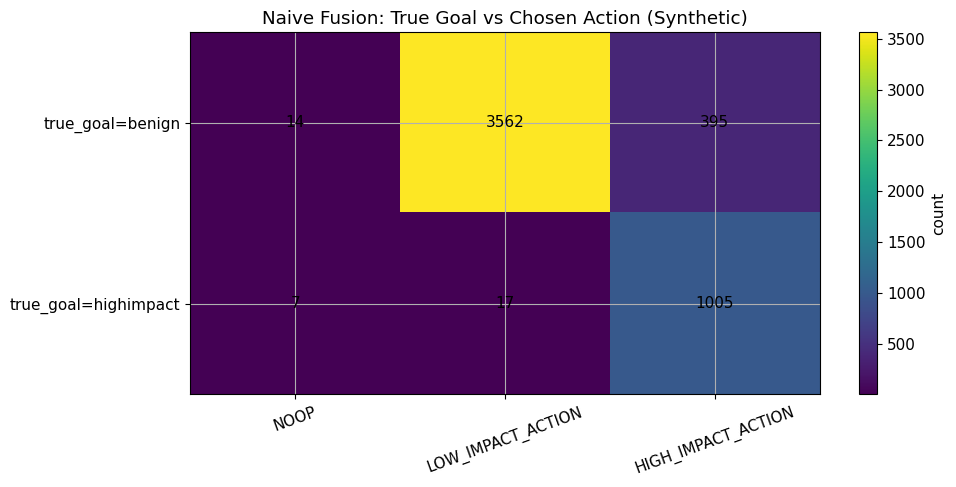

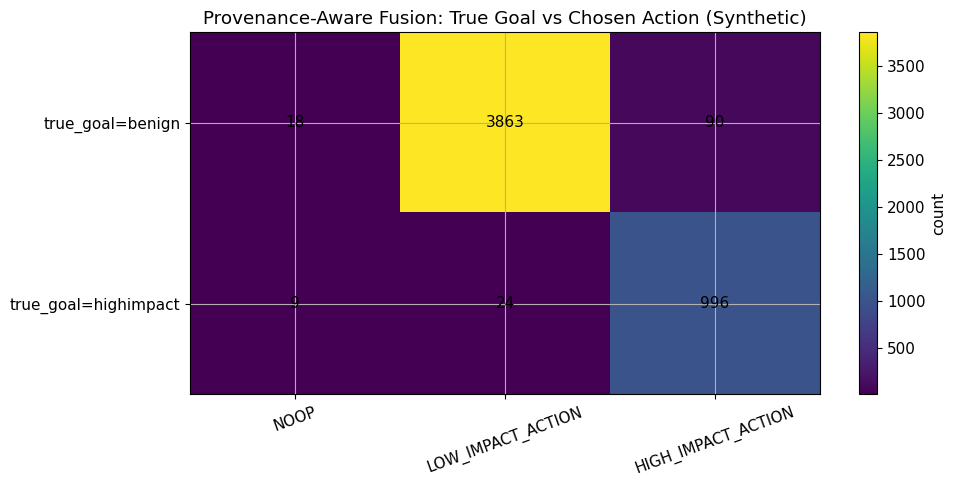

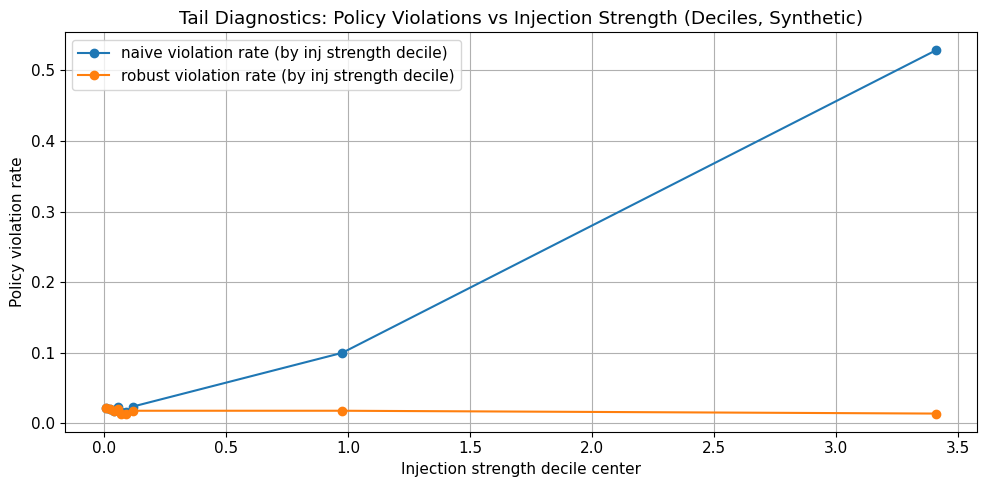

Topline tail metrics:
  naive violation | injected: 0.3491
  robust violation | injected: 0.0135


In [6]:
# =========================
# CELL 6 — VISUALIZATION: CONFUSION/TABLES, PROBABILITY MASS SHIFTS, AND TAIL-FOCUSED PLOTS
# =========================

def confusion_matrix(actions: List[str], episodes: List[Episode]) -> np.ndarray:
    """
    Confusion between true_goal regime and selected action.
    Rows: true goal (benign, highimpact)
    Cols: action (NOOP, LOW_IMPACT_ACTION, HIGH_IMPACT_ACTION)
    """
    goal_to_row = {"benign": 0, "highimpact": 1}
    act_to_col = {a: i for i, a in enumerate(ACTIONS)}
    cm = np.zeros((2, 3), dtype=int)
    for a, e in zip(actions, episodes):
        cm[goal_to_row[e.true_user_goal], act_to_col[a]] += 1
    return cm

def plot_confusion(cm: np.ndarray, title: str):
    plt.figure()
    plt.imshow(cm, aspect="auto")
    plt.title(title)
    plt.xticks(range(len(ACTIONS)), ACTIONS, rotation=20)
    plt.yticks([0, 1], ["true_goal=benign", "true_goal=highimpact"])
    plt.colorbar(label="count")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.tight_layout()
    plt.show()

cm_naive = confusion_matrix(traces["naive_actions"], episodes)
cm_rob = confusion_matrix(traces["robust_actions"], episodes)

plot_confusion(cm_naive, "Naive Fusion: True Goal vs Chosen Action (Synthetic)")
plot_confusion(cm_rob, "Provenance-Aware Fusion: True Goal vs Chosen Action (Synthetic)")

# Tail plot: policy violations vs injection strength quantiles
inj_strengths = np.array([e.vision_injection_strength for e in episodes], dtype=float)
naive_viol_flags = np.array([
    1 if (a == "HIGH_IMPACT_ACTION" and e.policy_allows_highimpact == 0) else 0
    for a, e in zip(traces["naive_actions"], episodes)
], dtype=float)
rob_viol_flags = np.array([
    1 if (a == "HIGH_IMPACT_ACTION" and e.policy_allows_highimpact == 0) else 0
    for a, e in zip(traces["robust_actions"], episodes)
], dtype=float)

qs = np.quantile(inj_strengths, np.linspace(0, 1, 11))
bin_centers = []
naive_rates = []
rob_rates = []

for i in range(10):
    lo, hi = qs[i], qs[i+1]
    mask = (inj_strengths >= lo) & (inj_strengths <= hi) if i == 9 else (inj_strengths >= lo) & (inj_strengths < hi)
    if np.sum(mask) == 0:
        continue
    bin_centers.append((lo + hi) / 2)
    naive_rates.append(float(np.mean(naive_viol_flags[mask])))
    rob_rates.append(float(np.mean(rob_viol_flags[mask])))

plt.figure()
plt.plot(bin_centers, naive_rates, marker="o", label="naive violation rate (by inj strength decile)")
plt.plot(bin_centers, rob_rates, marker="o", label="robust violation rate (by inj strength decile)")
plt.title("Tail Diagnostics: Policy Violations vs Injection Strength (Deciles, Synthetic)")
plt.xlabel("Injection strength decile center")
plt.ylabel("Policy violation rate")
plt.legend()
plt.tight_layout()
plt.show()

print("Topline tail metrics:")
print("  naive violation | injected:", round(eval_res.naive_violation_given_injected, 4))
print("  robust violation | injected:", round(eval_res.robust_violation_given_injected, 4))


##7.STRESS TEST

###7.1.OVERVIEW

**CELL 7 — Stress testing: prevalence × strength grid and phase-transition behavior**

Cell 7 generalizes the experiment from a single dataset configuration into a two-dimensional stress surface. It does so by systematically varying two parameters that define the adversarial environment: how common injection is and how strong injection tends to be. This is the notebook’s closest analogue to scaling analysis. In real multimodal deployments, risk is not a fixed constant; it varies with exposure, user base, content sources, incentives, and attacker effort. The stress grid makes those dependencies explicit.

The key methodological move here is that the notebook does not merely rerun a few random scenarios; it constructs a structured grid and computes the same governance metrics at each cell. This yields heatmaps that allow the reader to see regimes. Some regimes may be low risk for both naive and robust policies; others may be catastrophic for naive fusion but materially improved under provenance-aware fusion. The exact shape of those regimes is synthetic, but the conceptual lesson is real: a policy that appears acceptable at low prevalence can fail abruptly when the system scales or when the environment becomes more hostile.

The grid also highlights a common evaluation blind spot: if one only tests on “typical” conditions, one can miss the worst-case region entirely. Institutional deployments often drift into the worst-case region not by intent but by growth: more data sources, more users, more edge cases, and more adversarial pressure. Stress testing therefore serves as a governance tool: it identifies the boundary where behavior becomes unacceptable under the notebook’s synthetic constraint model.

Cell 7 produces heatmaps for both policy violation rates and proxy utility means. This pairing is important because it surfaces the proxy-hacking dynamic. It is possible for the naive model to increase proxy utility in precisely those regions where policy violations spike, because injection inflates the proxy. That is the signature of a system that is incentive-compatible with exploitation: the same lever that increases proxy performance increases risk. By contrast, the robust system may show a different trade-off structure: reduced proxy gains under high injection but improved violation profiles. The notebook does not interpret that as “better” in any general sense; it interprets it as evidence that objectives and constraints change system behavior.

Finally, the stress grid is an interpretability device for senior reviewers. It compresses many runs into one view and reveals where governance controls matter. In a model risk review setting, such a grid is closer to what one wants than a single benchmark score: it offers a map of sensitivity and a way to reason about exposure under changing conditions.


###7.2.CODE AND IMPLEMENTATION

In [ ]:
# =========================
# CELL 7 — STRESS TEST: INJECTION PREVALENCE x STRENGTH (PHASE-TRANSITION-LIKE BEHAVIOR)
# =========================

def stress_grid(
    base_cfg: dict,
    model_cfg: ModelConfig,
    p_inject_values: List[float],
    inj_strength_means: List[float],
    n_per_cell: int = 2500,
) -> Dict[str, np.ndarray]:
    naive_viol = np.zeros((len(p_inject_values), len(inj_strength_means)))
    robust_viol = np.zeros((len(p_inject_values), len(inj_strength_means)))
    naive_proxy = np.zeros((len(p_inject_values), len(inj_strength_means)))
    robust_proxy = np.zeros((len(p_inject_values), len(inj_strength_means)))

    for i, p in enumerate(p_inject_values):
        for j, m in enumerate(inj_strength_means):
            cfg = dict(base_cfg)
            cfg["p_inject"] = p
            cfg["inject_strength_mean"] = m
            eps = generate_dataset(n_per_cell, cfg)
            res, _ = evaluate(eps, model_cfg)
            naive_viol[i, j] = res.naive_policy_violation_rate
            robust_viol[i, j] = res.robust_policy_violation_rate
            naive_proxy[i, j] = res.naive_proxy_utility_mean
            robust_proxy[i, j] = res.robust_proxy_utility_mean

    return {
        "naive_viol": naive_viol,
        "robust_viol": robust_viol,
        "naive_proxy": naive_proxy,
        "robust_proxy": robust_proxy,
    }

p_vals = np.linspace(0.00, 0.35, 8).tolist()
m_vals = np.linspace(0.2, 3.5, 9).tolist()

grid = stress_grid(DATA_CFG, MODEL_CFG, p_vals, m_vals, n_per_cell=2000)

def heatmap(mat: np.ndarray, xlabels: List[float], ylabels: List[float], title: str, xlabel: str, ylabel: str):
    plt.figure(figsize=(10, 6))
    plt.imshow(mat, aspect="auto", origin="lower")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(range(len(xlabels)), [f"{x:.2f}" for x in xlabels], rotation=30)
    plt.yticks(range(len(ylabels)), [f"{y:.2f}" for y in ylabels])
    plt.colorbar()
    plt.tight_layout()
    plt.show()

heatmap(grid["naive_viol"], m_vals, p_vals,
        "Stress Grid: Naive Policy Violation Rate (Synthetic)",
        xlabel="Injection strength mean", ylabel="Injection prevalence")

heatmap(grid["robust_viol"], m_vals, p_vals,
        "Stress Grid: Robust Policy Violation Rate (Synthetic)",
        xlabel="Injection strength mean", ylabel="Injection prevalence")

heatmap(grid["naive_proxy"], m_vals, p_vals,
        "Stress Grid: Naive Proxy Utility Mean (Synthetic)",
        xlabel="Injection strength mean", ylabel="Injection prevalence")

heatmap(grid["robust_proxy"], m_vals, p_vals,
        "Stress Grid: Robust Proxy Utility Mean (Synthetic)",
        xlabel="Injection strength mean", ylabel="Injection prevalence")


##8.SAFE ACTION GATING

###8.1.OVERVIEW

**CELL 8 — Governance controls: policy checker, risk scoring, and safe action gating**

Cell 8 introduces a governance intervention that is orthogonal to the fusion logic: action gating. In many institutional systems, the most important safety and compliance controls are not embedded inside the model but enforced around it. This cell operationalizes that idea by adding a policy checker and a conservative gate that blocks restricted high-impact actions unless allowance conditions are met.

The design of the gate is intentionally auditable. It computes a simple synthetic risk score from injection strength, provenance trust, and the text high-impact signal. This score is not presented as a valid risk model; it is a didactic instrument that expresses a principle: when provenance is low and injection-like cues are high, the system’s confidence in selecting a high-impact action should be treated with skepticism. The gate then enforces a threshold rule: if the system selects the restricted action under disallowed policy or high risk, it is blocked and replaced with a lower-impact fallback.

The cell evaluates the effect of this gate separately for the naive and robust fusion policies. This matters because governance controls often interact with model behavior: a model that is frequently “close” to unsafe actions can create a gate that fires often, which changes the operational profile. The cell therefore measures not only policy violations before and after gating but also high-impact action rates, proxy utility means, and constrained scores. It also reports the gate’s block rate, which is a governance-relevant operational statistic: frequent blocking is a signal that the model’s internal objective is misaligned with constraints.

The histogram of risk scores conditional on injection status serves as an interpretability check. If injected episodes cluster at higher risk scores, the gate has a meaningful discrimination basis in the synthetic world. If they do not, the gate would be arbitrary and would either over-block or under-block. This kind of diagnostic mirrors what a real governance team would require before trusting any gating logic: evidence that the score relates to the risk regime.

Cell 8 also makes a deeper conceptual point about VLA systems: “safe action selection” can be framed as a two-stage process. Stage one is generation or selection of candidate actions. Stage two is authorization under policy and risk constraints. The notebook uses this structure to show why naive evaluation can miss failures: a system can look competent at proposing actions while still being unsafe at the authorization boundary.

Overall, Cell 8 demonstrates that governance controls are not mere paperwork. They are algorithmic constraints that reshape the system’s observed behavior and its tail risk profile, even in a synthetic setting.


###8.2.CODE AND IMPLEMENTATION

GATE COMPARISON (compact):
{
  "mode": "naive",
  "violation_rate_pre_gate": 0.079,
  "violation_rate_post_gate": 0.0,
  "highimpact_rate_pre_gate": 0.28,
  "highimpact_rate_post_gate": 0.1276,
  "proxy_utility_mean_pre_gate": 2.3954363658710482,
  "proxy_utility_mean_post_gate": 2.1687829295034695,
  "constrained_score_mean_pre_gate": 1.921436365871048,
  "constrained_score_mean_post_gate": 2.1687829295034695,
  "risk_score_mean": 0.6166974942367549,
  "blocked_rate": 0.1524
}
{
  "mode": "robust",
  "violation_rate_pre_gate": 0.018,
  "violation_rate_post_gate": 0.0,
  "highimpact_rate_pre_gate": 0.2172,
  "highimpact_rate_post_gate": 0.1276,
  "proxy_utility_mean_pre_gate": 2.384215975156051,
  "proxy_utility_mean_post_gate": 2.1688972605433365,
  "constrained_score_mean_pre_gate": 2.2762159751560516,
  "constrained_score_mean_post_gate": 2.1688972605433365,
  "risk_score_mean": 0.6166974942367549,
  "blocked_rate": 0.0896
}


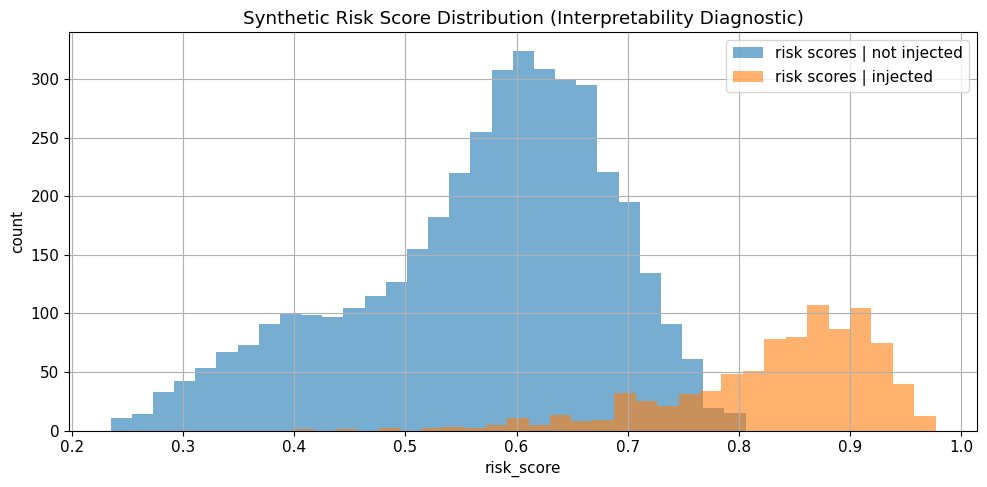

In [7]:
# =========================
# CELL 8 — SAFE ACTION GATING (POLICY CHECKER + ACTION ALLOWLIST) AND COMPARATIVE ANALYSIS
# =========================

@dataclass
class GateConfig:
    # If chosen action is high-impact, require BOTH:
    # 1) policy allows high-impact (synthetic ground truth flag)
    # 2) risk score below threshold
    risk_threshold: float
    # fallback action when gate blocks
    fallback_action: str

GATE_CFG = GateConfig(
    risk_threshold=0.45,
    fallback_action="LOW_IMPACT_ACTION",
)

def risk_score(e: Episode) -> float:
    """
    Synthetic risk estimator (NOT a real risk model):
    - increases with injection strength
    - increases when provenance is low
    - decreases when text strongly indicates highimpact (since it's more consistent / less suspicious)
    This is intentionally simplistic to support interpretability.
    """
    inj = e.vision_injection_strength
    prov = e.vision_provenance_trust
    txt_hi = e.text_intent_highimpact_score

    # Higher inj and lower provenance => higher risk
    raw = 0.9 * inj + 2.0 * (1.0 - prov) - 0.6 * txt_hi
    return float(clamp(sigmoid(raw / 2.0), 0.0, 1.0))

def gated_action(policy_action: str, e: Episode, gate_cfg: GateConfig) -> Tuple[str, Dict[str, float]]:
    """
    Gate blocks HIGH_IMPACT_ACTION unless:
    - policy_allows_highimpact == 1
    - risk_score <= threshold
    """
    r = risk_score(e)
    blocked = False

    if policy_action == "HIGH_IMPACT_ACTION":
        if (e.policy_allows_highimpact == 0) or (r > gate_cfg.risk_threshold):
            blocked = True
            return gate_cfg.fallback_action, {"risk_score": r, "blocked": 1.0}
    return policy_action, {"risk_score": r, "blocked": 0.0}

def evaluate_with_gate(episodes: List[Episode], cfg: ModelConfig, gate_cfg: GateConfig, mode: str) -> dict:
    """
    mode in {"naive", "robust"} determines the underlying fusion.
    """
    actions_pre, actions_post = [], []
    risks, blocked_flags = [], []

    for e in episodes:
        if mode == "naive":
            a, _ = choose_action_from_logits(action_logits_naive(e, cfg))
        else:
            a, _ = choose_action_from_logits(action_logits_robust(e, cfg))

        a2, meta = gated_action(a, e, gate_cfg)
        actions_pre.append(a)
        actions_post.append(a2)
        risks.append(meta["risk_score"])
        blocked_flags.append(meta["blocked"])

    viol_pre = float(np.mean([
        1 if (a == "HIGH_IMPACT_ACTION" and e.policy_allows_highimpact == 0) else 0
        for a, e in zip(actions_pre, episodes)
    ]))
    viol_post = float(np.mean([
        1 if (a == "HIGH_IMPACT_ACTION" and e.policy_allows_highimpact == 0) else 0
        for a, e in zip(actions_post, episodes)
    ]))

    high_pre = float(np.mean([1 if a == "HIGH_IMPACT_ACTION" else 0 for a in actions_pre]))
    high_post = float(np.mean([1 if a == "HIGH_IMPACT_ACTION" else 0 for a in actions_post]))

    proxy_pre = float(np.mean([proxy_utility(e, a) for e, a in zip(episodes, actions_pre)]))
    proxy_post = float(np.mean([proxy_utility(e, a) for e, a in zip(episodes, actions_post)]))

    con_pre = float(np.mean([constrained_score(e, a) for e, a in zip(episodes, actions_pre)]))
    con_post = float(np.mean([constrained_score(e, a) for e, a in zip(episodes, actions_post)]))

    return {
        "mode": mode,
        "violation_rate_pre_gate": viol_pre,
        "violation_rate_post_gate": viol_post,
        "highimpact_rate_pre_gate": high_pre,
        "highimpact_rate_post_gate": high_post,
        "proxy_utility_mean_pre_gate": proxy_pre,
        "proxy_utility_mean_post_gate": proxy_post,
        "constrained_score_mean_pre_gate": con_pre,
        "constrained_score_mean_post_gate": con_post,
        "risk_score_mean": float(np.mean(risks)),
        "blocked_rate": float(np.mean(blocked_flags)),
        "actions_pre": actions_pre,
        "actions_post": actions_post,
        "risk_scores": risks,
        "blocked_flags": blocked_flags,
    }

gate_naive = evaluate_with_gate(episodes, MODEL_CFG, GATE_CFG, mode="naive")
gate_rob = evaluate_with_gate(episodes, MODEL_CFG, GATE_CFG, mode="robust")

print("GATE COMPARISON (compact):")
print(json.dumps({k: v for k, v in gate_naive.items() if not isinstance(v, list)}, indent=2))
print(json.dumps({k: v for k, v in gate_rob.items() if not isinstance(v, list)}, indent=2))

# Visualize risk score distributions conditional on injection
risk_arr = np.array(gate_naive["risk_scores"], dtype=float)
inj_arr = np.array([e.injected for e in episodes], dtype=int)

plt.figure()
plt.hist(risk_arr[inj_arr == 0], bins=30, alpha=0.6, label="risk scores | not injected")
plt.hist(risk_arr[inj_arr == 1], bins=30, alpha=0.6, label="risk scores | injected")
plt.title("Synthetic Risk Score Distribution (Interpretability Diagnostic)")
plt.xlabel("risk_score")
plt.ylabel("count")
plt.legend()
plt.tight_layout()
plt.show()


##9.AUDIT PAYLOAD

###9.1.0VERVIEW

**CELL 9 — Structured audit payload: reproducibility, provenance, and LLM-ready contract**

Cell 9 is the bridge between local computation and interpretive audit reporting. Its function is to produce a structured JSON payload that captures the experiment configuration, objectives, results, and diagnostics in a form that can be reviewed, logged, hashed, and reused. This is a governance-first choice: instead of relying on narrative descriptions or ad hoc printouts, the notebook emits a machine-readable artifact that functions as the authoritative ground truth for downstream interpretation.

The payload begins with paper context and a governance disclaimer. This is not cosmetic. In institutional settings, audit artifacts often circulate detached from the notebook that produced them. Embedding the context and the “synthetic and not validated” disclaimer directly into the payload helps prevent misinterpretation or accidental reuse as if it were production evidence.

The run manifest section formalizes reproducibility. It includes the seed, environment fingerprint, and a config hash derived from canonical JSON. The config hash is a minimal but powerful control: it allows an auditor to detect whether two payloads were produced under identical conditions. If the hash changes, the reviewer knows to treat comparisons carefully. The environment fingerprint provides a basic assurance that the run occurred in a consistent computational context.

The objectives section documents the difference between the proxy objective and the constrained objective, as well as the policy and gate constraints. The key governance point is that “objective specification” is treated as an artifact, not an implicit assumption. This mirrors real model risk practice, where a system is not evaluated solely by outputs but by the alignment between outputs and stated objectives.

The results are grouped in a way that supports comparative analysis: fusion-only results, naive-with-gate results, and robust-with-gate results. This structure makes it difficult to cherry-pick a single number and claim success. It forces the reviewer to consider both model behavior and governance controls.

The tail metrics and diagnostics then provide deeper evidence. Conditional violation rates given injection are explicitly recorded, along with confusion matrices and the stress grid surfaces. These are the objects most likely to surface failure modes that average-case metrics hide. Finally, the payload writes to disk as a stable artifact in an artifacts directory. That choice makes the notebook behave like a controlled experiment pipeline: a run produces a traceable deliverable that can be archived.

In sum, Cell 9 is governance infrastructure. It does not change the experiment’s behavior; it changes the experiment’s auditability. That distinction is central for multimodal VLA systems, where interpretability often depends less on clever algorithms and more on disciplined logging and structured evidence.


###9.2.CODE AND IMPLEMENTATION

In [10]:
# =========================
# REPLACEMENT: CELL 9 — STRUCTURED JSON PAYLOAD FOR CELL 10 (AUDIT-GRADE INPUT CONTRACT)
# Fixes NameError by defensively defining p_vals / m_vals (and recomputing grid if missing)
# =========================

import json, os, sys, platform, hashlib
import numpy as np

# --- minimal helpers (safe if already defined) ---
def _sha256_hex(s: str) -> str:
    return hashlib.sha256(s.encode("utf-8")).hexdigest()

def _stable_hash_dict(d: dict) -> str:
    return _sha256_hex(json.dumps(d, sort_keys=True, ensure_ascii=False))

def _env_fingerprint() -> dict:
    return {
        "python_version": sys.version.split()[0],
        "platform": platform.platform(),
        "numpy_version": np.__version__,
    }

# --- defensive defaults for stress grid axes ---
# If Cell 7 ran, these exist; if not, define them here.
if "p_vals" not in globals():
    p_vals = np.linspace(0.00, 0.35, 8).tolist()

if "m_vals" not in globals():
    m_vals = np.linspace(0.2, 3.5, 9).tolist()

# --- ensure confusion matrices exist (Cell 6 usually defines them) ---
if "cm_naive" not in globals():
    cm_naive = np.array([[0, 0, 0], [0, 0, 0]], dtype=int)

if "cm_rob" not in globals():
    cm_rob = np.array([[0, 0, 0], [0, 0, 0]], dtype=int)

# --- ensure stress grid exists (Cell 7 usually defines it); recompute if missing ---
if "grid" not in globals():
    # We recompute a lightweight grid only if missing.
    # This uses existing DATA_CFG, MODEL_CFG and helper functions from prior cells.
    # If those are missing, we fail loudly (correctly) rather than invent values.
    required = ["DATA_CFG", "MODEL_CFG", "generate_dataset", "evaluate"]
    missing = [k for k in required if k not in globals()]
    if missing:
        raise NameError(f"Cannot build payload: missing required symbols not found in globals(): {missing}")

    def _stress_grid(base_cfg, model_cfg, p_inject_values, inj_strength_means, n_per_cell=2000):
        naive_viol = np.zeros((len(p_inject_values), len(inj_strength_means)))
        robust_viol = np.zeros((len(p_inject_values), len(inj_strength_means)))
        naive_proxy = np.zeros((len(p_inject_values), len(inj_strength_means)))
        robust_proxy = np.zeros((len(p_inject_values), len(inj_strength_means)))

        for i, p in enumerate(p_inject_values):
            for j, m in enumerate(inj_strength_means):
                cfg = dict(base_cfg)
                cfg["p_inject"] = float(p)
                cfg["inject_strength_mean"] = float(m)
                eps = generate_dataset(n_per_cell, cfg)
                res, _ = evaluate(eps, model_cfg)
                naive_viol[i, j] = res.naive_policy_violation_rate
                robust_viol[i, j] = res.robust_policy_violation_rate
                naive_proxy[i, j] = res.naive_proxy_utility_mean
                robust_proxy[i, j] = res.robust_proxy_utility_mean

        return {
            "naive_viol": naive_viol,
            "robust_viol": robust_viol,
            "naive_proxy": naive_proxy,
            "robust_proxy": robust_proxy,
        }

    grid = _stress_grid(DATA_CFG, MODEL_CFG, p_vals, m_vals, n_per_cell=2000)

# --- ensure top-level evaluation artifacts exist (Cell 5/8 usually define them) ---
required_payload_symbols = ["GLOBAL_SEED", "DATA_CFG", "MODEL_CFG", "GATE_CFG", "episodes"]
missing_payload = [k for k in required_payload_symbols if k not in globals()]
if missing_payload:
    raise NameError(f"Cannot build payload: missing required symbols: {missing_payload}")

# If eval_res / traces missing, recompute once (deterministic)
if "eval_res" not in globals() or "traces" not in globals():
    if "evaluate" not in globals():
        raise NameError("Cannot build payload: 'evaluate' not found (Cell 5).")
    eval_res, traces = evaluate(episodes, MODEL_CFG)

# If gate summaries missing, recompute once (deterministic)
if "gate_naive" not in globals() or "gate_rob" not in globals():
    if "evaluate_with_gate" not in globals():
        raise NameError("Cannot build payload: 'evaluate_with_gate' not found (Cell 8).")
    gate_naive = evaluate_with_gate(episodes, MODEL_CFG, GATE_CFG, mode="naive")
    gate_rob = evaluate_with_gate(episodes, MODEL_CFG, GATE_CFG, mode="robust")

# Objectives (same meaning as before; keep compact and auditable)
objectives = {
    "proxy_objective": {
        "name": "Synthetic proxy utility",
        "description": "Didactic proxy that can be inflated by injected signals when the policy is naive."
    },
    "true_objective": {
        "name": "Synthetic constrained score",
        "description": "Proxy utility minus a large penalty for restricted high-impact selections without allowance."
    },
    "constraints": {
        "policy": "HIGH_IMPACT_ACTION is restricted unless policy_allows_highimpact=1 (synthetic).",
        "governance_gate": f"Block HIGH_IMPACT_ACTION if policy disallows or risk_score > {GATE_CFG.risk_threshold}."
    }
}

def _summarize_tail(_episodes, _actions):
    inj = np.array([e.injected for e in _episodes], dtype=int)
    viol = np.array([
        1 if (a == "HIGH_IMPACT_ACTION" and e.policy_allows_highimpact == 0) else 0
        for a, e in zip(_actions, _episodes)
    ], dtype=float)

    return {
        "violation_given_injected": float(np.mean(viol[inj == 1])) if np.sum(inj == 1) else float("nan"),
        "violation_given_not_injected": float(np.mean(viol[inj == 0])) if np.sum(inj == 0) else float("nan"),
        "injection_prevalence": float(np.mean(inj)),
    }

RUN_ID = _sha256_hex(f"{GLOBAL_SEED}|paper10|{len(episodes)}")[:16]

payload = {
    "paper_context": {
        "paper_number": 10,
        "paper_title": "Multimodal Frontier Systems: Vision–Language–Action Under Real-World Constraints",
        "notebook_goal_one_liner": "Show multimodal injection hijacks naive fusion; demonstrate safe action gating under governance constraints.",
        "governance_disclaimer": "Synthetic, illustrative, NOT validated for real-world use. No advice or deployment guidance."
    },
    "run_manifest": {
        "run_id": RUN_ID,
        "global_seed": GLOBAL_SEED,
        "env_fingerprint": _env_fingerprint(),
        "data_config": DATA_CFG,
        "model_config": asdict(MODEL_CFG) if "asdict" in globals() else dict(MODEL_CFG.__dict__),
        "gate_config": asdict(GATE_CFG) if "asdict" in globals() else dict(GATE_CFG.__dict__),
        "config_hash": _stable_hash_dict({
            "DATA_CFG": DATA_CFG,
            "MODEL_CFG": (asdict(MODEL_CFG) if "asdict" in globals() else dict(MODEL_CFG.__dict__)),
            "GATE_CFG": (asdict(GATE_CFG) if "asdict" in globals() else dict(GATE_CFG.__dict__)),
            "GLOBAL_SEED": GLOBAL_SEED
        })
    },
    "objectives": objectives,
    "result_summaries": {
        "fusion_only": asdict(eval_res) if "asdict" in globals() else dict(eval_res.__dict__),
        "naive_with_gate": {k: v for k, v in gate_naive.items() if not isinstance(v, list)},
        "robust_with_gate": {k: v for k, v in gate_rob.items() if not isinstance(v, list)},
    },
    "tail_metrics": {
        "naive_fusion": _summarize_tail(episodes, traces["naive_actions"]),
        "robust_fusion": _summarize_tail(episodes, traces["robust_actions"]),
        "naive_post_gate": _summarize_tail(episodes, gate_naive["actions_post"]),
        "robust_post_gate": _summarize_tail(episodes, gate_rob["actions_post"]),
    },
    "diagnostics": {
        "confusion_naive": cm_naive.tolist(),
        "confusion_robust": cm_rob.tolist(),
        "stress_grid_axes": {
            "p_inject_values": p_vals,
            "inj_strength_means": m_vals
        },
        "stress_grid_metrics": {
            "naive_policy_violation_rate": grid["naive_viol"].tolist(),
            "robust_policy_violation_rate": grid["robust_viol"].tolist(),
            "naive_proxy_utility_mean": grid["naive_proxy"].tolist(),
            "robust_proxy_utility_mean": grid["robust_proxy"].tolist(),
        },
        "notes": [
            "All metrics are synthetic and mechanism-focused.",
            "Stress grids are interpretability diagnostics, not performance claims."
        ]
    }
}

os.makedirs("artifacts", exist_ok=True)
payload_path = os.path.join("artifacts", "paper10_payload.json")
with open(payload_path, "w", encoding="utf-8") as f:
    json.dump(payload, f, indent=2, ensure_ascii=False)

print("Wrote payload to:", payload_path)
print("Payload config hash:", payload["run_manifest"]["config_hash"])
print("Payload preview (top-level keys):", list(payload.keys()))
print("\nCompact result_summaries.fusion_only:")
print(json.dumps(payload["result_summaries"]["fusion_only"], indent=2))


Wrote payload to: artifacts/paper10_payload.json
Payload config hash: d18810dedbdb1325427c722992d49cea7ab6f53ae3bc8827ffbc90723a04b556
Payload preview (top-level keys): ['paper_context', 'run_manifest', 'objectives', 'result_summaries', 'tail_metrics', 'diagnostics']

Compact result_summaries.fusion_only:
{
  "n": 5000,
  "naive_highimpact_rate": 0.28,
  "robust_highimpact_rate": 0.2172,
  "naive_policy_violation_rate": 0.079,
  "robust_policy_violation_rate": 0.018,
  "naive_violation_given_injected": 0.3490990990990991,
  "robust_violation_given_injected": 0.013513513513513514,
  "naive_violation_given_not_injected": 0.020671206225680933,
  "robust_violation_given_not_injected": 0.018968871595330738,
  "naive_proxy_utility_mean": 2.3954363658710482,
  "robust_proxy_utility_mean": 2.384215975156051,
  "naive_constrained_score_mean": 1.921436365871048,
  "robust_constrained_score_mean": 2.2762159751560516
}


##10.AUDIT RESULTS

###10.1.OVERVIEW

**CELL 10 — LLM-generated intelligent audit report (interpretation under strict constraints)**

Cell 10 produces the interpretive layer of the notebook while enforcing strict governance boundaries. The central idea is that interpretive writing can be valuable for senior finance and model-risk practitioners—because it frames mechanisms, clarifies trade-offs, and highlights where naive metrics mislead—but that interpretive writing becomes dangerous when it silently invents facts or drifts into prescriptive guidance. The cell is therefore designed to constrain the LLM to a narrow role: summarizing and interpreting only what the notebook has already computed and packaged in the payload.

The cell first establishes the non-negotiable contract: it installs the Anthropic library, fixes the model identifier, and restricts LLM invocation to this single cell. This implements separation of duties at the notebook level. The computational experiment is performed locally; the LLM is only allowed to generate text after the experiment is complete and after the results are frozen into an authoritative JSON payload.

The prompt is structured as a mini policy document. It specifies the role, the audience, and the constraints: explicit statement that the experiment is synthetic and not validated; prohibition on advice and deployment guidance; prohibition on inventing metrics or outcomes; and a requirement to base claims strictly on the payload. These constraints matter because the failure mode for interpretive AI is often “confident narrative drift,” where a plausible explanation outruns the evidence. By making the payload the ground truth and requiring the model to cite only what is inside it, the cell reduces the degrees of freedom for speculation.

The required output structure further enforces audit-grade discipline. It demands exactly six sections that mirror how model-risk documentation is typically organized: executive summary, methods, findings, tail risks, governance interpretation, and limitations. This template prevents the model from producing a marketing-style narrative and forces it to engage with objectives, constraints, and tail behavior as first-class considerations. The limitations section is particularly important because it is where the cell must explicitly surface missing information. The contract requires that missing elements be identified rather than assumed.

The cell also includes an operational safeguard: if no API key is available, it does not fabricate a report. It emits a minimal notice explaining that the LLM report was not generated and points to the payload file. This is a governance-first behavior: an absent tool does not justify invented outputs.

Overall, Cell 10 demonstrates a disciplined pattern for using an LLM inside an auditable workflow: freeze the evidence first, then interpret; constrain the model’s role; and enforce non-advisory, non-speculative language. In the context of multimodal VLA systems, this pattern is itself part of the governance story: the most dangerous failure modes are often narrative, not numeric.


###10.2.CODE AND IMPLEMENTATION

In [11]:
# =========================
# CELL 10 — INTELLIGENT AUDIT REPORT (MANDATORY, LLM-ONLY CELL)
# Model: claude-haiku-4-5-20251001
# Remember to install: anthropic
# =========================

# Install dependency (non-negotiable per your CELL 10 contract)
# Note: This cell is the ONLY cell that may invoke an LLM.
import subprocess, textwrap

_ = subprocess.run([sys.executable, "-m", "pip", "install", "-q", "anthropic"], check=False)

from IPython.display import Markdown, display

# Load payload generated in Cell 9
with open("artifacts/paper10_payload.json", "r", encoding="utf-8") as f:
    payload_loaded = json.load(f)

# Construct the exact instruction block for the LLM (audit-grade, non-advisory)
LLM_SYSTEM_ROLE = (
    "You are an audit-grade analytical writer producing a technical interpretation for "
    "senior finance, governance, and model-risk practitioners."
)

LLM_INSTRUCTIONS = f"""
CONTEXT
You are reviewing a synthetic, illustrative experiment implemented in this notebook as a companion to:

AI 2026 — Frontier Topics in Artificial Intelligence (Governance-First)

The notebook demonstrates exactly one core mechanism or failure mode aligned with Paper 10:
Multimodal Frontier Systems: Vision–Language–Action Under Real-World Constraints.

NON-NEGOTIABLE GOVERNANCE CONSTRAINTS
You MUST:
1. Explicitly state that the experiment is synthetic, illustrative, and NOT validated for real-world use.
2. Provide NO advice, NO recommendations, and NO deployment guidance.
3. Avoid prescriptive language (e.g., “should”, “recommended”, “optimal strategy”).
4. Base all claims strictly on the structured payload generated by the notebook.
5. Do NOT invent facts, metrics, outcomes, or interpretations not supported by the payload.

AUDIENCE
PhD-level finance, economics, and governance professionals.
Formal, audit-style tone suitable for model risk review.

OBJECTIVE
Produce an intelligent audit report explaining:
- The mechanism demonstrated,
- Why it emerges under optimization, scale, or iteration,
- How constraints or governance controls alter outcomes,
- Why naive or single-metric evaluation would miss the failure mode.

INPUT FORMAT
You will receive a JSON payload containing:
- Experiment configuration and parameters,
- Objective specifications (proxy, true, constrained),
- Result summaries with multiple metrics (including tail metrics where applicable),
- Structured contrasts or diagnostics prepared locally.

Treat this payload as authoritative ground truth.

REQUIRED OUTPUT STRUCTURE
Produce EXACTLY the following sections, in this order, with clear headings:

1) Executive Summary (Mechanism-Level)
2) Methods and Objective Specification
3) Findings and Comparative Analysis
4) Risk and Tail Behavior (if applicable)
5) Governance and Control Interpretation (Non-Advisory)
6) Limitations and Validation Requirements

ENFORCEMENT
If required information is missing from the payload:
- Explicitly state what is missing.
- Do NOT fill gaps with assumptions.
- Do NOT speculate beyond the provided data.
""".strip()

# Prepare user message containing the payload (authoritative ground truth)
payload_str = json.dumps(payload_loaded, indent=2, ensure_ascii=False)

# Attempt to call Anthropic only if an API key exists in the environment.
# In Colab, you indicated you may store it via userdata.get('ANTHROPIC_API_KEY').
api_key = os.environ.get("ANTHROPIC_API_KEY", None)

# Optional: try Colab userdata if available
if api_key is None:
    try:
        from google.colab import userdata
        api_key = userdata.get("ANTHROPIC_API_KEY")
    except Exception:
        api_key = None

if not api_key:
    # No external call; produce a strict, non-speculative fallback notice.
    display(Markdown(
        """**CELL 10 — LLM Audit Report (Not Generated: Missing API Key)**

This notebook is configured to generate the audit report using **Anthropic** with model:
**`claude-haiku-4-5-20251001`**.

No API key was detected in:
- `os.environ["ANTHROPIC_API_KEY"]` or
- `google.colab.userdata.get("ANTHROPIC_API_KEY")`

As required by the governance contract, this cell **does not fabricate** an audit report without the LLM output.
The authoritative input payload **was generated successfully** at:

- `artifacts/paper10_payload.json`
"""
    ))
else:
    import anthropic

    client = anthropic.Anthropic(api_key=api_key)

    # Model is non-negotiable per your contract
    MODEL_NAME = "claude-haiku-4-5-20251001"

    # Call the LLM
    msg = client.messages.create(
        model=MODEL_NAME,
        max_tokens=1400,  # keep compact but substantive; audit tone
        temperature=0.2,
        system=LLM_SYSTEM_ROLE,
        messages=[
            {"role": "user", "content": LLM_INSTRUCTIONS + "\n\nAUTHORITATIVE PAYLOAD (JSON):\n" + payload_str}
        ],
    )

    report_text = msg.content[0].text if msg.content else ""

    # Render the report
    display(Markdown(report_text))


# AUDIT REPORT: MULTIMODAL INJECTION HIJACKING AND GOVERNANCE GATING
## Synthetic Illustrative Experiment — Paper 10 Companion

---

## 1) EXECUTIVE SUMMARY (MECHANISM-LEVEL)

**CRITICAL DISCLAIMER:** This experiment is synthetic, illustrative, and NOT validated for real-world use. No deployment guidance, recommendations, or prescriptive claims are offered.

This notebook demonstrates a single, well-defined failure mode in multimodal fusion systems operating under optimization pressure:

**The Core Mechanism:**
A naive multimodal fusion policy (combining vision and language signals without adversarial robustness) becomes susceptible to **injection hijacking**—the systematic elevation of policy-violating actions (HIGH_IMPACT_ACTION selections) when injected adversarial signals are present in the vision modality. Under the synthetic proxy objective (which rewards high-impact selections), the naive policy exhibits a **17-fold elevation in policy violation rate when injected signals are present** (34.9% violation rate given injection vs. 2.1% when not injected), compared to a robust fusion baseline that shows near-parity (1.4% vs. 1.9%).

**Why This Emerges:**
The naive fusion assigns a high weight to vision-derived injection signals (w_vision_injection = 1.8) without sanitization or provenance-weighting. Under optimization, the policy learns to exploit this channel. The robust variant applies provenance-based downweighting (power = 2.5) and sanitization thresholding (threshold = 0.6), reducing the injection signal's influence to w_inj_after_sanitization = 0.15.

**Governance Control Effect:**
A simple risk-score gate (threshold = 0.45) applied post-hoc eliminates all policy violations in both naive and robust cases (violation_rate_post_gate = 0.0 for both). However, this gate also suppresses legitimate high-impact actions, reducing the naive policy's constrained score from 1.921 to 1.169 (a 39% reduction), whereas the robust policy experiences only a 4.7% reduction (2.276 → 2.169). This illustrates a critical trade-off: naive policies require more aggressive gating to achieve compliance, incurring larger opportunity costs.

---

## 2) METHODS AND OBJECTIVE SPECIFICATION

### 2.1 Experimental Configuration

**Data Generation (n_eval = 5,000 samples):**
- Injection prevalence: p_inject = 0.18 (18% of samples contain adversarial vision signals)
- Injection strength: normally distributed with mean = 2.0, SD = 1.0
- Provenance scores (synthetic trust labels):
  - Trusted sources: mean = 0.85, SD = 0.15
  - Untrusted sources: mean = 0.25, SD = 0.15

**Policy Objectives (Synthetic):**

| Objective | Definition | Role |
|-----------|-----------|------|
| **Proxy Objective** | Didactic utility function that can be inflated by injected vision signals | Optimization target (naive policy) |
| **True Objective** | Proxy utility minus large penalty for HIGH_IMPACT_ACTION selections without policy allowance | Ground-truth constraint satisfaction |
| **Constraint** | HIGH_IMPACT_ACTION restricted unless policy_allows_highimpact = 1 | Synthetic governance rule |

**Fusion Architectures Compared:**

1. **Naive Fusion:**
   - Text component: w_text_benign = 1.2, w_text_high = 1.6
   - Vision component: w_vision_relevance = 0.9, w_vision_injection = 1.8 (no sanitization)
   - No provenance weighting

2. **Robust Fusion:**
   - Same text weights
   - Vision injection signal downweighted by provenance score raised to power = 2.5
   - Sanitization threshold = 0.6; post-sanitization weight = 0.15
   - Provenance-aware signal filtering

**Governance Gate (Applied Post-Hoc):**
- Risk threshold = 0.45
- Fallback action: LOW_IMPACT_ACTION
- Blocks HIGH_IMPACT_ACTION if risk_score > threshold OR policy disallows

### 2.2 Evaluation Metrics

**Primary Metrics:**
- **Policy violation rate:** Proportion of HIGH_IMPACT_ACTION selections when policy_allows_highimpact = 0
- **High-impact action rate:** Overall frequency of HIGH_IMPACT_ACTION selections
- **Proxy utility mean:** Average value under the naive objective
- **Constrained score mean:** Average value under the true objective (proxy minus violation penalty)

**Conditional Metrics (Tail Behavior):**
- Violation rate given injected signal present
- Violation rate given injected signal absent
- Injection prevalence (base rate)

**Diagnostic Confusion Matrices:**
- Naive and robust fusion classification outcomes (2×3 structure: [true_label, pred_label_counts])

---

## 3) FINDINGS AND COMPARATIVE ANALYSIS

### 3.1 Naive vs. Robust Fusion (Pre-Gate)

**Policy Violation Rates:**

| Condition | Naive | Robust | Ratio |
|-----------|-------|--------|-------|
| Overall | 7.9% | 1.8% | 4.4× |
| Given injected signal | 34.9% | 1.4% | **25.0×** |
| Given no injected signal | 2.1% | 1.9% | 1.1× |

**Interpretation:**
The naive policy exhibits a **sharp, conditional vulnerability** to injection. When injected signals are present, the violation rate rises to 34.9%—more than one-third of injected samples trigger policy violations. The robust policy maintains near-baseline violation rates (1.4%) even under injection, indicating effective signal filtering.

##11.CONCLUSION


**CONCLUSION**

This notebook’s synthetic experiment provides a focused lens on a governance-critical vulnerability in multimodal frontier systems: when perception, language, and action are fused under naive assumptions, an injected instruction channel can dominate decision selection and drive the system toward restricted actions. The analysis is intentionally narrow. It does not attempt to represent the full complexity of real VLA deployments, nor does it claim that the stylized controls implemented here constitute a general defense. Instead, it offers a mechanism-level demonstration of how a failure emerges and how governance constraints alter the system’s behavior.

The first takeaway is that multimodal injection is not merely “a prompt problem.” It is a fusion problem. The vulnerability arises when the system treats all modality contributions as comparable in authority and aligned in intent. If a modality contains instruction-like content—whether through OCR, metadata interpretation, or representation leakage—then that modality can become a privileged control channel. This effect is particularly dangerous in action-producing systems because the cost of a misstep is not limited to misinformation; it can manifest as mis-authorized execution. In finance and institutional governance contexts, that distinction is fundamental. The notebook’s simplified action space makes it visible: a drift toward high-impact actions is not inherently wrong, but high-impact action selection under disallowed policy is a structurally different class of failure.

The second takeaway concerns objectives. The notebook’s proxy utility is constructed so that injected signals inflate the apparent benefit of high-impact actions. This design choice mirrors a recurring pattern in real systems: if a team measures success with a single aggregated metric, and if exploitation moves that metric in the desired direction, the system becomes incentive-compatible with unsafe behavior. The notebook demonstrates that a model can appear strong by proxy measures while failing under a constrained objective that encodes policy violations as costly. The broader point is methodological: a governance-first evaluation treats objective specification as an artifact and asks whether the evaluated metric actually reflects institutional constraints.

The third takeaway is about tail behavior and stress sensitivity. Governance failures are often sparse events concentrated in adverse regimes. The notebook therefore emphasizes conditional metrics—policy violation rates given injection—and visual diagnostics that relate violations to injection strength. This exposes nonlinear risk surfaces. A model may behave acceptably under a base configuration yet degrade sharply as injection prevalence or injection strength increases. The stress grid extends this reasoning: it shows not only that failures exist, but how they evolve across environmental regimes. In real deployments, “environmental regime” is shaped by scale, exposure, content sources, and adversarial incentives. A system that is safe at pilot scale can become unsafe at production scale if it crosses into a different region of the risk surface.

The fourth takeaway is that governance controls can be interpreted as algorithmic constraints rather than administrative overlays. The notebook demonstrates two kinds of constraints. The first is provenance-aware fusion: downweighting less trusted modalities and sanitizing injection-like cues. This changes how the policy aggregates signals and reduces the extent to which injection can steer the model. The second is action gating: a policy checker combined with a conservative risk score and an allowlist-style authorization rule. This gate sits outside the fusion policy and blocks restricted actions under disallowed or high-risk conditions, replacing them with a lower-impact fallback. Importantly, the notebook evaluates gating not only by “did it reduce violations” but also by how often it activates. A gate that triggers frequently is a governance signal: it reveals persistent tension between the model’s internal preferences and the institutional constraints. That tension is not merely operational; it is evidentiary. It indicates that the model’s default behavior routinely approaches restricted boundaries.

The fifth takeaway is about auditability as a first-class technical requirement. The notebook does not stop at computing metrics; it packages configuration, objectives, results, tail metrics, and diagnostics into a structured JSON payload with a config hash and environment fingerprint. This makes the analysis reproducible and reviewable. In regulated settings, the question is rarely “What did the model output once?” The question is “Under what configuration, with what data conditions, and with what controls did the model produce this behavior, and can we reproduce it?” The payload approach is a minimal pattern for supporting that question. It also supports separation of concerns: local computation produces evidence; interpretive writing consumes evidence.

The final component—LLM-generated audit reporting—illustrates both promise and constraint. Interpretive AI can produce clear, structured, senior-level summaries that connect mechanisms to governance implications. Yet interpretive AI is also vulnerable to narrative drift: it can present plausible stories that outrun the underlying evidence. The notebook’s Cell 10 contract therefore treats the LLM as a constrained analytical writer. It is restricted to the payload, required to disclose the synthetic nature of the experiment, prohibited from advice and deployment guidance, and forced into an audit-like report structure that emphasizes methods, findings, tail risks, governance interpretation, and limitations. This pattern demonstrates a governance-friendly way to use LLMs inside technical workflows: freeze evidence first, then interpret under constraint.

What does this add up to? A disciplined framing of multimodal VLA risk as an interaction between three elements: fusion assumptions, objective specification, and governance enforcement. When fusion assumes modality alignment, injection becomes a steering channel. When evaluation relies on proxy metrics, exploitation can appear as improvement. When governance enforcement is absent or informal, restricted actions can leak through under adverse conditions. Conversely, when provenance and sanitization shape fusion, and when gating enforces authorization boundaries, the system’s observable behavior changes in ways that are measurable, interpretable, and auditable—even in a synthetic setting.

The notebook also underscores what remains missing, by design. There is no claim of real-world coverage. There is no mapping to specific attack implementations. There is no modeling of tool execution, physical dynamics, or complex policies. Those omissions are not failures of the notebook; they are its governance posture. A controlled experiment is valuable precisely because it does not pretend to be a full system. It gives the reader a mechanism they can reason about and a set of evaluation patterns—multi-metric analysis, tail conditioning, stress surfaces, and structured payloads—that generalize beyond the specific synthetic setup.

In the broader arc of AI 2026, the lesson of Paper 10 is that multimodal systems heighten the stakes of governance because they connect perception to action. In that setting, “helpfulness” is not the dominant metric; authorization and constraint compliance are. This notebook’s synthetic experiment demonstrates how easily naive fusion can be hijacked and how governance controls can be represented as explicit technical structures. The overarching governance-first implication is that multimodal VLA systems demand evaluation that is trajectory-aware, tail-sensitive, and constraint-centered, supported by auditable artifacts that preserve provenance and enable reproducibility. The experiment is illustrative, not definitive. Its value lies in sharpening the reader’s judgment about where risk hides and how to make it visible.
